In [45]:
#!pip install medmnist

In [46]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torchvision import transforms
from PIL import Image

from medmnist import TissueMNIST

import wandb
from datetime import datetime


In [47]:
# Load all splits of the dataset
train_dataset = TissueMNIST(split="train", download=True, size=64)
val_dataset = TissueMNIST(split="val", download=True, size=64)
test_dataset = TissueMNIST(split="test", download=True, size=64)


Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz
Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz
Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz


In [48]:
# Exploratory data analisis


# Get class names
class_names = [
    'Proximal Tubule',      # PT
    'Thick Ascending Limb', # TAL
    'Distal Con. Tubule',   # DCT
    'Collecting Duct',      # CD
    'Leukocytes',          # White blood cells
    'Podocytes',           # Podocytes
    'Glomerular Endo.',    # Glomerular endothelial
    'Peritubular Endo.'    # Peritubular endothelial
]

# Function to analyze dataset statistics
def analyze_dataset(dataset, split_name):
    # Get all labels and convert to regular integers
    labels = [int(y.item()) for _, y in dataset]
    label_counts = Counter(labels)
    
    print(f"\n{split_name} Set Statistics:")
    print(f"Total samples: {len(dataset)}")
    print("\nClass distribution:")
    for label, count in sorted(label_counts.items()):
        percentage = (count / len(dataset)) * 100
        print(f"{class_names[label]}: {count} samples ({percentage:.2f}%)")
    
    return labels

# Analyze each split
train_labels = analyze_dataset(train_dataset, "Training")
val_labels = analyze_dataset(val_dataset, "Validation")
test_labels = analyze_dataset(test_dataset, "Test")







Training Set Statistics:
Total samples: 165466

Class distribution:
Proximal Tubule: 53075 samples (32.08%)
Thick Ascending Limb: 7814 samples (4.72%)
Distal Con. Tubule: 5866 samples (3.55%)
Leukocytes: 11789 samples (7.12%)
Podocytes: 7705 samples (4.66%)
Glomerular Endo.: 39203 samples (23.69%)
Peritubular Endo.: 24608 samples (14.87%)

Validation Set Statistics:
Total samples: 23640

Class distribution:
Proximal Tubule: 7582 samples (32.07%)
Thick Ascending Limb: 1117 samples (4.73%)
Distal Con. Tubule: 838 samples (3.54%)
Leukocytes: 1684 samples (7.12%)
Podocytes: 1101 samples (4.66%)
Glomerular Endo.: 5601 samples (23.69%)
Peritubular Endo.: 3516 samples (14.87%)

Test Set Statistics:
Total samples: 47280

Class distribution:
Proximal Tubule: 15165 samples (32.07%)
Thick Ascending Limb: 2233 samples (4.72%)
Distal Con. Tubule: 1677 samples (3.55%)
Leukocytes: 3369 samples (7.13%)
Podocytes: 2202 samples (4.66%)
Glomerular Endo.: 11201 samples (23.69%)
Peritubular Endo.: 7031 sa

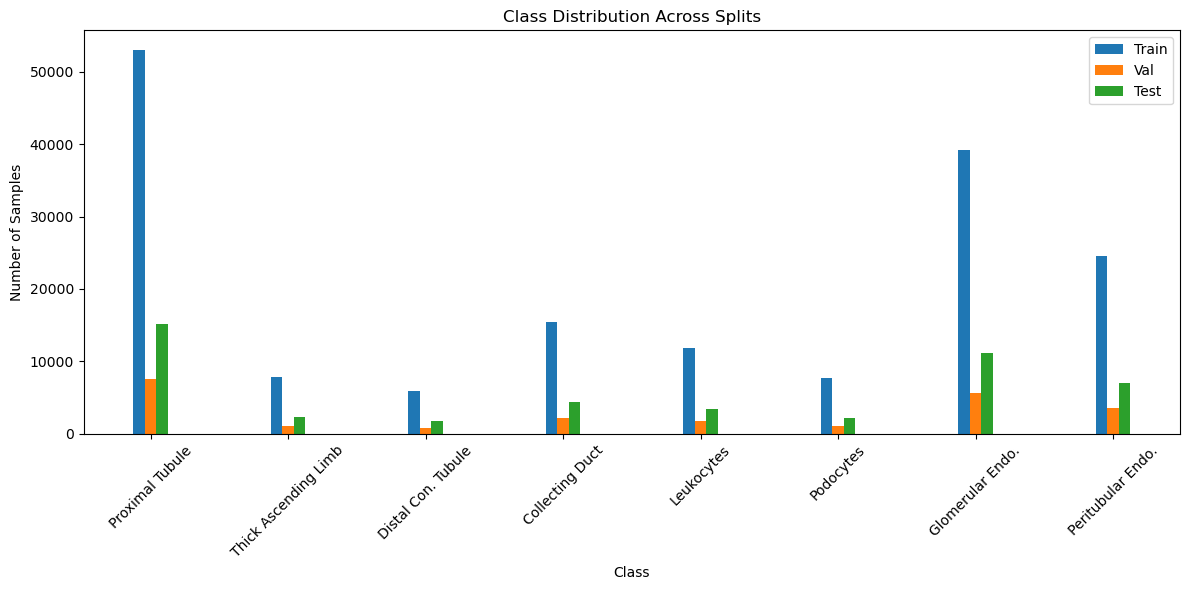

In [49]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.hist([train_labels, val_labels, test_labels], 
         label=['Train', 'Val', 'Test'],
         bins=np.arange(9) - 0.5,
         rwidth=0.25,
         align='mid')
plt.title('Class Distribution Across Splits')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(range(8), class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x156b59d00>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


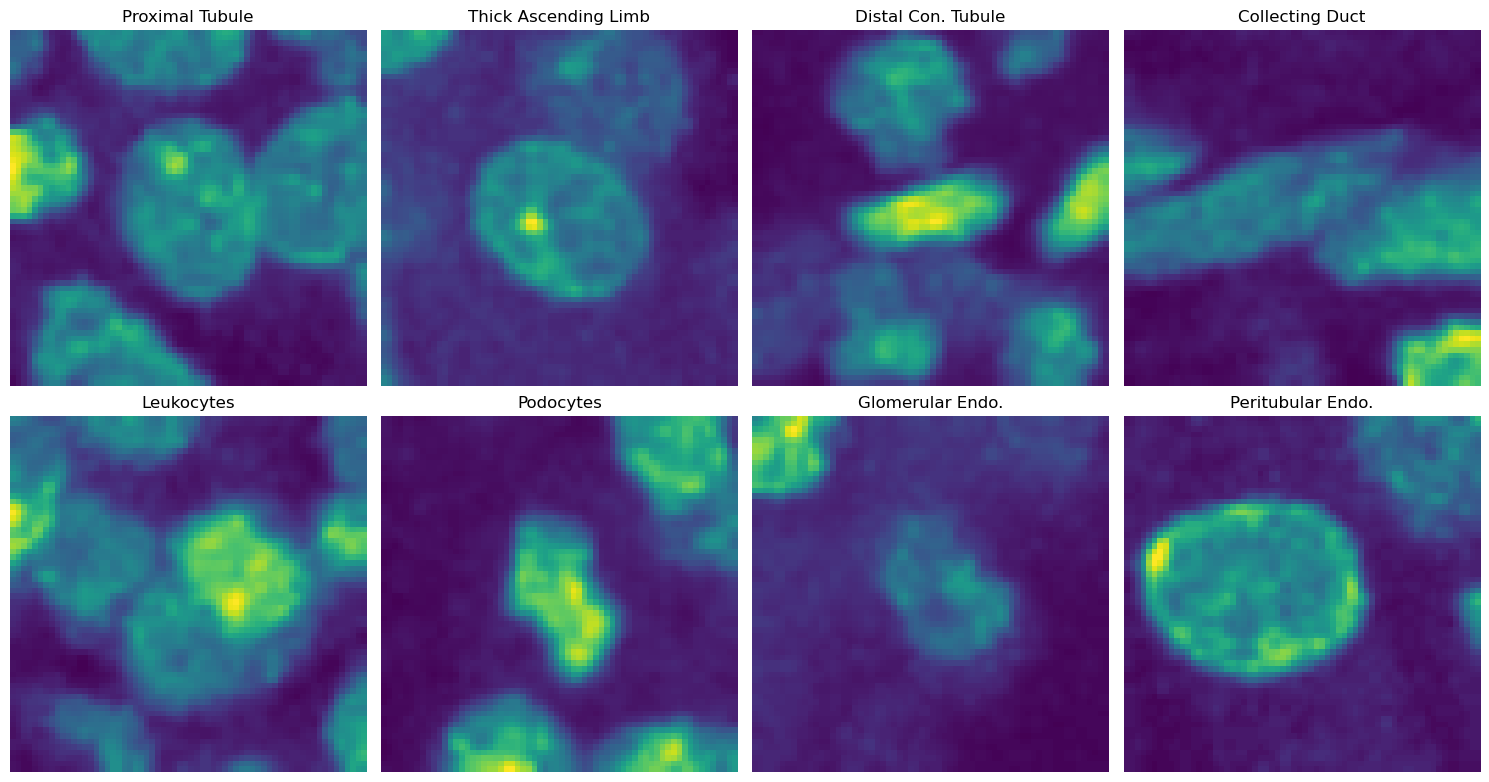

In [50]:
# Display sample images from each class
plt.figure(figsize=(15, 8))
for i in range(8):
    # Find first image of each class in training set
    for idx, (image, label) in enumerate(train_dataset):
        if int(label.item()) == i:
            plt.subplot(2, 4, i + 1)
            plt.title(class_names[i])
            plt.imshow(np.array(image))  # Convert PIL Image to numpy array
            plt.axis('off')
            break
plt.tight_layout()
plt.show()


In [51]:
# Basic image statistics
def analyze_image_statistics(dataset):
    images = []
    for image, _ in dataset:
        # Convert PIL Image to numpy array
        img_array = np.array(image)
        images.append(img_array)
    
    images = np.stack(images)
    print("Number of dimensions:", images[0].ndim)
    print("\nImage Statistics:")
    print(f"Image shape: {images[0].shape}")
    print(f"Value range: [{images.min():.2f}, {images.max():.2f}]")
    print(f"Mean pixel value: {images.mean():.2f}")
    print(f"Std pixel value: {images.std():.2f}")

    # Calculate per-channel statistics if RGB
    if len(images[0].shape) == 3:
        for i in range(images[0].shape[2]):
            print(f"\nChannel {i} statistics:")
            print(f"Mean: {images[:,:,:,i].mean():.2f}")
            print(f"Std: {images[:,:,:,i].std():.2f}")
    
    return images

train_images = analyze_image_statistics(train_dataset)



Number of dimensions: 2

Image Statistics:
Image shape: (64, 64)
Value range: [0.00, 255.00]
Mean pixel value: 26.26
Std pixel value: 25.13


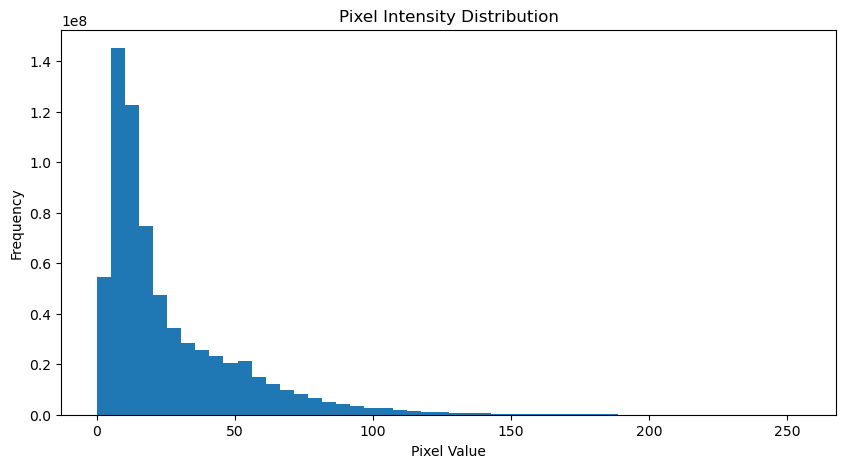


Dataset Information:
Number of training samples: 165466
Number of validation samples: 23640
Number of test samples: 47280

Sample image type: <class 'PIL.Image.Image'>
Sample image size: (64, 64)
Sample image mode: L


In [52]:
# Display intensity distribution
plt.figure(figsize=(10, 5))
plt.hist(train_images.ravel(), bins=50)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Print dataset info
print("\nDataset Information:")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Get a sample image and print its details
sample_image, _ = train_dataset[0]
print(f"\nSample image type: {type(sample_image)}")
print(f"Sample image size: {sample_image.size}")
print(f"Sample image mode: {sample_image.mode}")  # Color mode (RGB, L, etc.)

In [53]:
# !pip install torchsummary

Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz
Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz
Using downloaded and verified file: /Users/gwilk/.medmnist/tissuemnist_64.npz


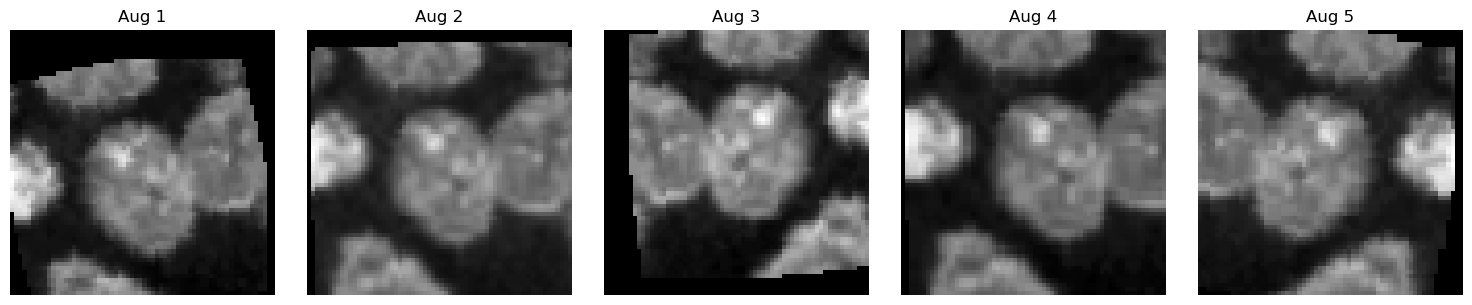

wandb: Currently logged in as: grzegorzwilkpl (wwsi-projects). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch [1/10]
Train Loss: 3.4021, Train Acc: 36.23%
Val Loss: 1.4627, Val Acc: 46.78%
------------------------------------------------------------
Epoch [2/10]
Train Loss: 3.0927, Train Acc: 42.15%
Val Loss: 1.3954, Val Acc: 44.02%
------------------------------------------------------------
Epoch [3/10]
Train Loss: 2.9867, Train Acc: 43.67%
Val Loss: 1.3633, Val Acc: 44.00%
------------------------------------------------------------


KeyboardInterrupt: 

: 

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import TissueMNIST

# Set random seed for reproducibility
torch.manual_seed(42)

# Check for MPS (Mac GPU) availability
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Define the CNN architecture
class TissueCNN(nn.Module):
    def __init__(self):
        super(TissueCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 8)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Define separate transforms for training and validation
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomRotation(20),  # Increased rotation
        transforms.RandomAffine(
            degrees=0,
            translate=(0.15, 0.15),  # Increased translation
            scale=(0.85, 1.15),      # Increased scaling
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),  # Added vertical flip
        transforms.ColorJitter(
            brightness=0.3,  # Increased brightness adjustment
            contrast=0.3,    # Increased contrast adjustment
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    return train_transform, val_transform



def visualize_augmentations(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    
    # Get a single image
    image, label = dataset[0]
    
    # Apply transforms multiple times to the same image
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        
        # Get transforms and apply to the same image
        train_transform, _ = get_transforms()
        augmented_image = train_transform(dataset[0][0])
        
        # Convert to numpy and display
        img_np = augmented_image.squeeze().numpy()
        plt.imshow(img_np, cmap='gray')
        plt.title(f'Aug {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Calculate class weights
def compute_class_weights(train_loader):
    all_labels = []
    for _, labels in train_loader:
        # Convert labels to numpy array and flatten them
        labels_np = labels.squeeze().numpy()  # squeeze to remove extra dimensions
        all_labels.extend(labels_np)
    
    # Convert to numpy array
    all_labels = np.array(all_labels)
    
    # Count samples per class
    class_counts = np.bincount(all_labels)
    
    # Calculate weights (inverse of frequency)
    weights = 1. / class_counts
    # Normalize weights
    weights = weights / weights.sum() * len(class_counts)
    
    return torch.FloatTensor(weights)

# Data preparation
def prepare_data(batch_size=32):
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Load datasets with appropriate transforms
    train_dataset = TissueMNIST(
        split="train",
        transform=train_transform,
        download=True,
        size=64
    )
    
    val_dataset = TissueMNIST(
        split="val",
        transform=val_transform,
        download=True,
        size=64
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader



# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, patience=3):

    # Initialize wandb
    run = wandb.init(
        project="tissue-classification",  # your project name
        config=config,
        name=f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    )
    
    # Log model architecture
    wandb.watch(model, log="all")   

    device = get_device()
    model = model.to(device)
    
    # Calculate class weights
    class_weights = compute_class_weights(train_loader).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        


        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

            # Update metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.squeeze().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        epoch_val_loss = val_loss/len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        
        # Log metrics to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_acc': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_acc': epoch_val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        })

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f'model_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), model_path)
            wandb.save(model_path)  # Save to wandb
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                # Load best model
                model.load_state_dict(torch.load('best_model.pth'))
                break
                
        print('-' * 60)
    # Close wandb run
    wandb.finish()
    return model

# Main execution
if __name__ == "__main__":
    # Login to wandb (do this once) or from terminal wandb login
    #wandb.login()
    
    # wandb config
    config = {
        'architecture': 'TissueCNN',
        'dataset': 'TissueMNIST',   
        'epochs': 10,
        'batch_size': 32,
        'learning_rate': 0.0001,
        'weight_decay': 1e-4,
        'optimizer': 'Adam',
        'scheduler': 'ReduceLROnPlateau',
        'early_stopping_patience': 3,
    }   

    # Prepare data with augmentation
    train_loader, val_loader = prepare_data(batch_size=32)
    
    # Visualize some augmented samples
    train_dataset = TissueMNIST(split="train", download=True, size=64)
    visualize_augmentations(train_dataset)
    
    # Initialize and train model as before
    model = TissueCNN()
    trained_model = train_model(model, train_loader, val_loader)